In [1]:
# Import Libraries and Load Data 
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the sliding window data
file_path = r'C:\Users\Shadow\Desktop\GIT_X\GIT_PE\thesis\Final\Sliding\pre_modi_data.csv'
data = pd.read_csv(file_path, low_memory=False)

# Update the customer identifier column name
id_column = 'Customer No'  # Change from 'customer_id' to 'Customer No'

# Ensure 'Customer No' is included
if id_column in data.columns:
    customer_ids = data[id_column]
    data = data.drop(columns=[id_column])
    print(f"'{id_column}' column found and separated.")
else:
    print(f"'{id_column}' column not found in data.")
    customer_ids = pd.Series([np.nan]*len(data))

# Convert data to numeric, handling errors by coercion
data = data.apply(pd.to_numeric, errors='coerce')

# Combine 'Customer No' with data for alignment
data[id_column] = customer_ids

# Drop rows where the target variable (last column before 'Customer No') is NaN
target_column_index = data.shape[1] - 2  # Index of the target column before 'Customer No'
target_column = data.columns[target_column_index]
data = data.dropna(subset=[target_column]).reset_index(drop=True)

# Extract 'Customer No' after dropping NaNs
customer_ids = data[id_column].reset_index(drop=True)
data = data.drop(columns=[id_column])

# Optionally fill NaN values in feature columns with column mean
data = data.fillna(data.mean())

# Identify and remove zero variance columns
from sklearn.feature_selection import VarianceThreshold

# Remove features with zero variance
selector = VarianceThreshold(threshold=0.0)
selector.fit(data.drop(columns=[target_column]))
zero_variance_columns = data.drop(columns=[target_column]).columns[~selector.get_support()]
if len(zero_variance_columns) > 0:
    print(f"Removing zero variance columns: {list(zero_variance_columns)}")
    data = data.drop(columns=zero_variance_columns)
else:
    print("No zero variance columns found.")

# Define the target column (assuming it's still the last column)
target_column = data.columns[-1]

# Split features and target
X = data.drop(columns=[target_column])
y = data[target_column].values.reshape(-1, 1)

# Print shapes for confirmation
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')
print(f'Number of customer IDs: {len(customer_ids)}')

# Check if there is data available after preprocessing
if X.shape[0] == 0:
    raise ValueError("No data available for training after preprocessing.")



'Customer No' column found and separated.
No zero variance columns found.
Features shape: (17761, 75)
Target shape: (17761, 1)
Number of customer IDs: 17761


In [2]:
# Preprocess Data and Split into Train/Test Sets

# For time-series data, using chronological split instead of random
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
customer_ids_train = customer_ids.iloc[:split_index].reset_index(drop=True)
customer_ids_test = customer_ids.iloc[split_index:].reset_index(drop=True)

# Scale data after splitting to avoid data leakage
# scaler_X = StandardScaler()
# scaler_y = StandardScaler()

from sklearn.preprocessing import RobustScaler

scaler_X = RobustScaler()
scaler_y = RobustScaler()

# Fit scalers on training data and transform both training and test data
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Check for NaNs or infinite values after scaling
def check_for_invalid_values(array, array_name):
    if np.isnan(array).any():
        print(f"{array_name} contains NaN values.")
    if np.isinf(array).any():
        print(f"{array_name} contains infinite values.")

check_for_invalid_values(X_train, "X_train")
check_for_invalid_values(X_test, "X_test")
check_for_invalid_values(y_train, "y_train")
check_for_invalid_values(y_test, "y_test")

# If invalid values are found, raise an error
if np.isnan(X_train).any() or np.isinf(X_train).any():
    raise ValueError("X_train contains invalid values after scaling.")
if np.isnan(X_test).any() or np.isinf(X_test).any():
    raise ValueError("X_test contains invalid values after scaling.")
if np.isnan(y_train).any() or np.isinf(y_train).any():
    raise ValueError("y_train contains invalid values after scaling.")
if np.isnan(y_test).any() or np.isinf(y_test).any():
    raise ValueError("y_test contains invalid values after scaling.")

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)  # No shuffling for time-series
test_loader = DataLoader(test_dataset, batch_size=64)

print('Data preprocessing and splitting completed.')

Data preprocessing and splitting completed.


In [3]:
# Define the N-Beats Block and Model
# class NBeatsBlock(nn.Module):
#     def __init__(self, input_size, hidden_size, theta_size):
#         super(NBeatsBlock, self).__init__()
#         self.fc = nn.Sequential(
#             nn.Linear(input_size, hidden_size),
#             nn.ReLU(),
#             nn.Linear(hidden_size, hidden_size),
#             nn.ReLU(),
#             nn.Linear(hidden_size, theta_size)
#         )

#     def forward(self, x):
#         theta = self.fc(x)
#         return theta

class NBeatsBlock(nn.Module):
    def __init__(self, input_size, hidden_size, theta_size, dropout_rate=0.2):
        super(NBeatsBlock, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, theta_size)
        )
    def forward(self, x):
        theta = self.fc(x)
        return theta


class NBeatsModel(nn.Module):
    def __init__(self, input_size, hidden_size, theta_size, num_blocks):
        super(NBeatsModel, self).__init__()
        self.blocks = nn.ModuleList([NBeatsBlock(input_size, hidden_size, theta_size) for _ in range(num_blocks)])

    def forward(self, x):
        forecast = torch.zeros(x.shape[0], 1).to(x.device)
        for block in self.blocks:
            f = block(x)
            forecast = forecast + f
        return forecast

print('Model classes defined.')

Model classes defined.


In [4]:
# Model parameters
input_size = X_train.shape[1]
hidden_size = 256
theta_size = 1
num_blocks = 3
# Initialize the model
model = NBeatsModel(input_size=input_size, hidden_size=hidden_size, theta_size=theta_size, num_blocks=num_blocks)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

print('Model initialized and moved to device:', device)

Model initialized and moved to device: cpu


In [5]:
# Training loop
# num_epochs = 100
num_epochs = 200
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        if torch.isnan(loss):
            print("Encountered NaN loss at epoch:", epoch)
            raise ValueError("Loss is NaN, stopping training.")
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if epoch % 10 == 0 or epoch == num_epochs:
        avg_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.4f}')

print('Training completed.')

Epoch [10/200], Loss: 0.1565
Epoch [20/200], Loss: 0.1328
Epoch [30/200], Loss: 0.1193
Epoch [40/200], Loss: 0.1025
Epoch [50/200], Loss: 0.0914
Epoch [60/200], Loss: 0.0865
Epoch [70/200], Loss: 0.0779
Epoch [80/200], Loss: 0.0704
Epoch [90/200], Loss: 0.0665
Epoch [100/200], Loss: 0.0627
Epoch [110/200], Loss: 0.0578
Epoch [120/200], Loss: 0.0537
Epoch [130/200], Loss: 0.0523
Epoch [140/200], Loss: 0.0498
Epoch [150/200], Loss: 0.0469
Epoch [160/200], Loss: 0.0464
Epoch [170/200], Loss: 0.0434
Epoch [180/200], Loss: 0.0422
Epoch [190/200], Loss: 0.0419
Epoch [200/200], Loss: 0.0391
Training completed.


In [6]:
# Evaluation
model.eval()
with torch.no_grad():
    test_loss = 0.0
    all_preds = []
    all_targets = []
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        test_loss += loss.item()
        all_preds.extend(y_pred.cpu().numpy())
        all_targets.extend(y_batch.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    print(f'Test Loss (MSE): {avg_test_loss:.4f}')

# Inverse transform the predictions and actual targets
all_preds = np.array(all_preds).flatten()
all_targets = np.array(all_targets).flatten()

future_forecast = scaler_y.inverse_transform(all_preds.reshape(-1, 1)).flatten()
actual_y = scaler_y.inverse_transform(all_targets.reshape(-1, 1)).flatten()

# Check for NaNs or infinite values in predictions
if np.isnan(future_forecast).any() or np.isinf(future_forecast).any():
    raise ValueError("Predictions contain NaN or infinite values.")

# Ensure customer_ids_test is aligned with predictions
customer_ids_test = customer_ids_test.reset_index(drop=True)

# Calculate Evaluation Metrics
mae = mean_absolute_error(actual_y, future_forecast)
mse = mean_squared_error(actual_y, future_forecast)
rmse = np.sqrt(mse)
r2 = r2_score(actual_y, future_forecast)

print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R² (R-squared): {r2:.4f}')

Test Loss (MSE): 0.1545
Mean Absolute Error (MAE): 38.4876
Mean Squared Error (MSE): 3150.1155
Root Mean Squared Error (RMSE): 56.1259
R² (R-squared): 0.8346


In [7]:
# Save predictions to CSV

prediction_df = pd.DataFrame({
    'Customer No': customer_ids_test,
    'Actual': actual_y,
    'Predicted': future_forecast
})

prediction_df.to_csv('predictions.csv', index=False)
prediction_df.to_csv('predictions.csv', index=False)
print("Predictions saved to 'predictions.csv'")


Predictions saved to 'predictions.csv'


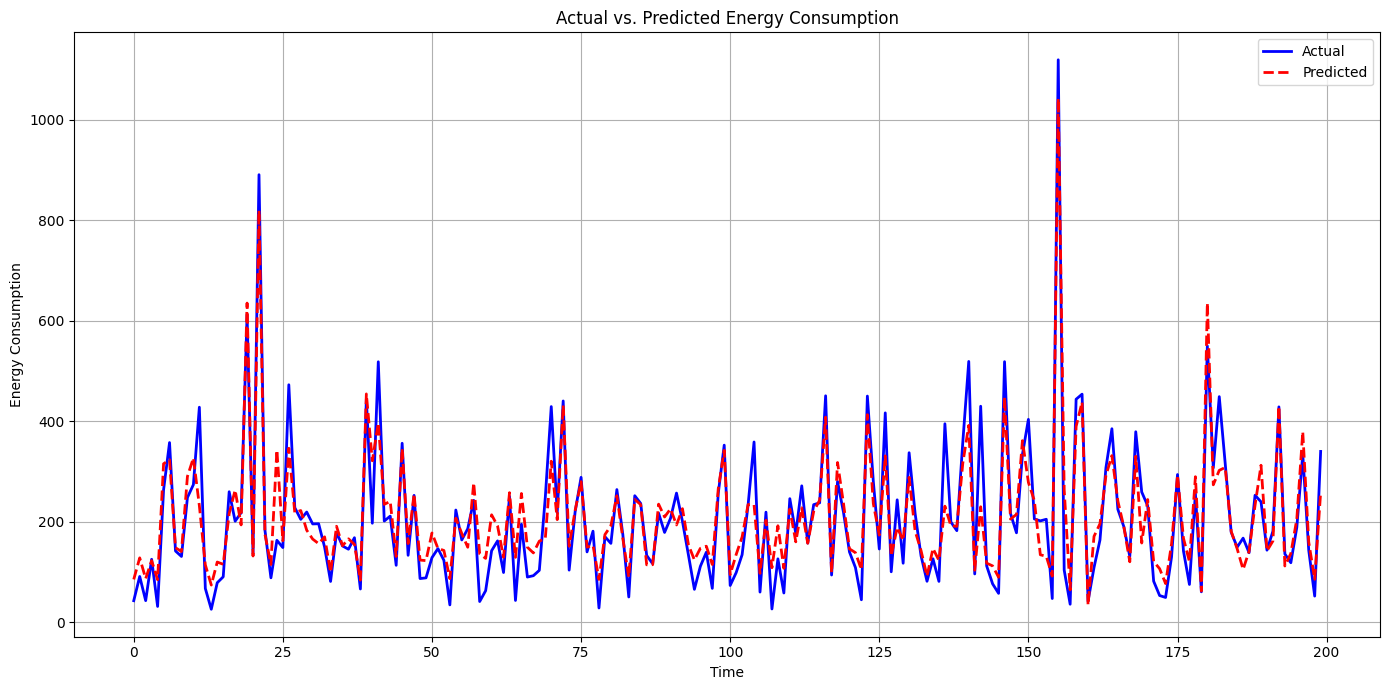

Actual vs. Predicted plot saved as 'actual_vs_predicted.png'


In [8]:
# Visualization
# Define the number of points to plot
num_points = 200
if len(actual_y) < num_points:
    num_points = len(actual_y)

# Select the subset for plotting
actual_plot = actual_y[-num_points:]
predicted_plot = future_forecast[-num_points:]

# Create a range for the x-axis
time = np.arange(len(actual_plot))

# Actual vs Predicted Plot
plt.figure(figsize=(14, 7))
plt.plot(time, actual_plot, label='Actual', color='blue', linewidth=2)
plt.plot(time, predicted_plot, label='Predicted', color='red', linestyle='--', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.title('Actual vs. Predicted Energy Consumption')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('actual_vs_predicted.png', dpi=300)
plt.show()

print("Actual vs. Predicted plot saved as 'actual_vs_predicted.png'")


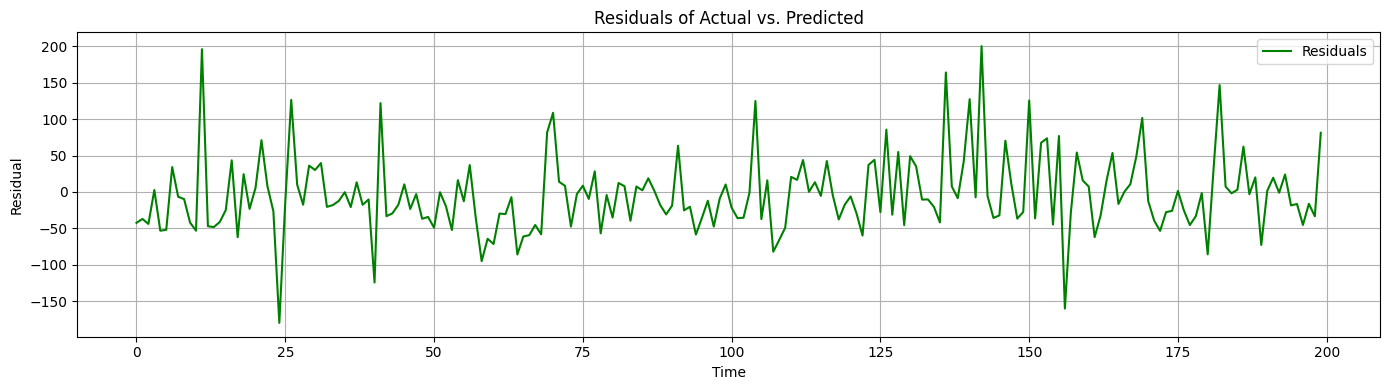

Residuals plot saved as 'residuals_plot.png'


In [9]:
# Residual Plot
residuals = actual_y - future_forecast

plt.figure(figsize=(14, 4))
plt.plot(time, residuals[-num_points:], label='Residuals', color='green')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.title('Residuals of Actual vs. Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('residuals_plot.png', dpi=300)
plt.show()

print("Residuals plot saved as 'residuals_plot.png'")
 

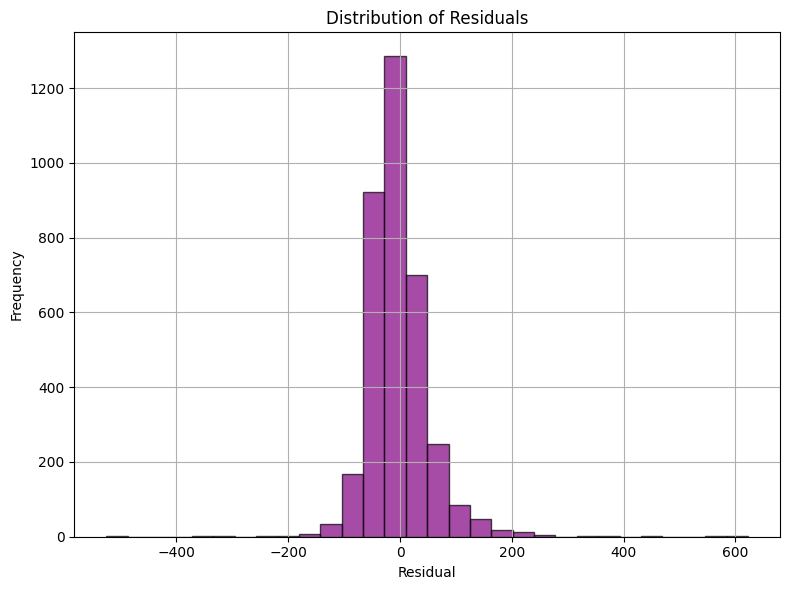

Error distribution plot saved as 'error_distribution.png'


In [10]:
# Error Distribution
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color='purple', edgecolor='k', alpha=0.7)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)
plt.tight_layout()
plt.savefig('error_distribution.png', dpi=300)
plt.show()

print("Error distribution plot saved as 'error_distribution.png'")


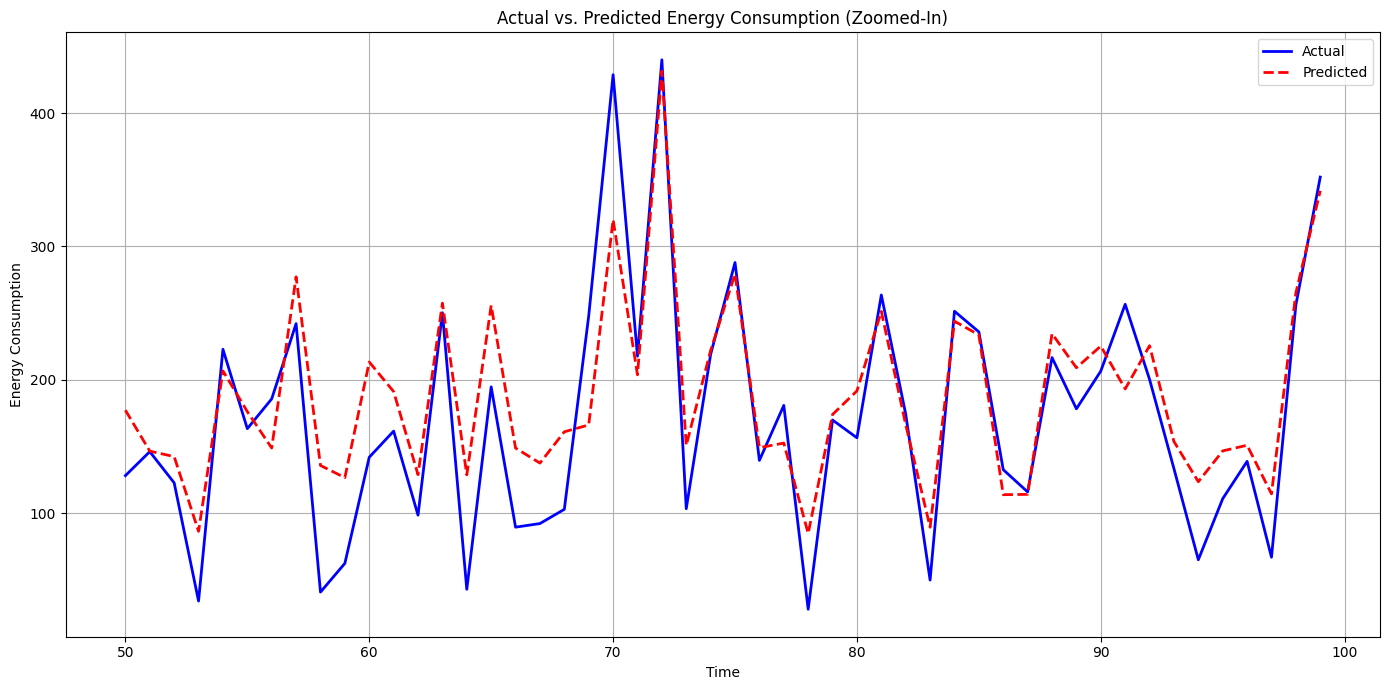

Zoomed-in plot saved as 'actual_vs_predicted_zoomed.png'


In [11]:
# Zoomed-In View
start = 50
end = 100
if end > len(time):
    end = len(time)
plt.figure(figsize=(14, 7))
plt.plot(time[start:end], actual_plot[start:end], label='Actual', color='blue', linewidth=2)
plt.plot(time[start:end], predicted_plot[start:end], label='Predicted', color='red', linestyle='--', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.title('Actual vs. Predicted Energy Consumption (Zoomed-In)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('actual_vs_predicted_zoomed.png', dpi=300)
plt.show()

print("Zoomed-in plot saved as 'actual_vs_predicted_zoomed.png'")
